# Random Forest Project 

For this project we will be exploring publicly available data from [LendingClub.com](www.lendingclub.com). Lending Club connects people who need money (borrowers) with people who have money (investors). Hopefully, as an investor you would want to invest in people who showed a profile of having a high probability of paying you back. We will try to create a model that will help predict this.

Lending club had a [very interesting year in 2016](https://en.wikipedia.org/wiki/Lending_Club#2016), so let's check out some of their data and keep the context in mind. This data is from before they even went public.

We will use lending data from 2007-2010 and be trying to classify and predict whether or not the borrower paid back their loan in full. You can download the data from [here](https://www.lendingclub.com/info/download-data.action) or just use the csv already provided. It's recommended you use the csv provided as it has been cleaned of NA values.

Here are what the columns represent:
* credit.policy: 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.
* purpose: The purpose of the loan (takes values "credit_card", "debt_consolidation", "educational", "major_purchase", "small_business", and "all_other").
* int.rate: The interest rate of the loan, as a proportion (a rate of 11% would be stored as 0.11). Borrowers judged by LendingClub.com to be more risky are assigned higher interest rates.
* installment: The monthly installments owed by the borrower if the loan is funded.
* log.annual.inc: The natural log of the self-reported annual income of the borrower.
* dti: The debt-to-income ratio of the borrower (amount of debt divided by annual income).
* fico: The FICO credit score of the borrower.
* days.with.cr.line: The number of days the borrower has had a credit line.
* revol.bal: The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).
* revol.util: The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available).
* inq.last.6mths: The borrower's number of inquiries by creditors in the last 6 months.
* delinq.2yrs: The number of times the borrower had been 30+ days past due on a payment in the past 2 years.
* pub.rec: The borrower's number of derogatory public records (bankruptcy filings, tax liens, or judgments).

# Import Libraries

**Import the usual libraries for pandas and plotting. You can import sklearn later on.**

In [1]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Get the Data

** Use pandas to read loan_data.csv as a dataframe called loans.**

In [3]:
df = pd.read_csv('loan_data.csv')

** Check out the data using pandas profiling.**

In [4]:
profile = ProfileReport(df, title='Pandas Profiling Report')

In [5]:
profile.to_widgets()

Summarize dataset:   0%|          | 0/28 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

# Exploratory Data Analysis

Let's do some data visualization! We'll use seaborn and pandas built-in plotting capabilities, but feel free to use whatever library you want. Don't worry about the colors matching, just worry about getting the main idea of the plot.

** Create a histogram of two FICO distributions on top of each other, one for each credit.policy outcome.**

*Note: This is pretty tricky, feel free to reference the solutions. You'll probably need one line of code for each histogram, I also recommend just using pandas built in .hist()*

Text(0.5, 0, 'FICO')

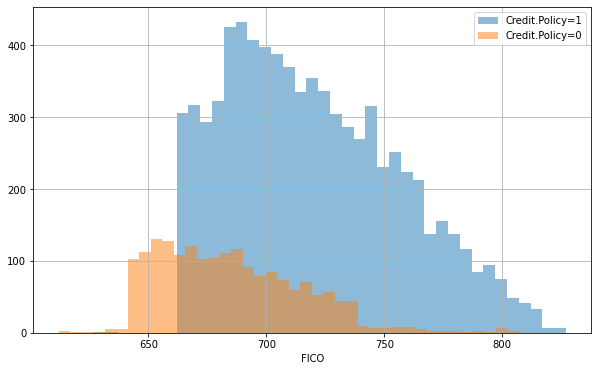

In [13]:
plt.figure(figsize=(10,6))
df[df['credit.policy']==1]['fico'].hist(bins=40, label='Credit.Policy=1', alpha=0.5, ls='dashed', lw=3)
df[df['credit.policy']==0]['fico'].hist(bins=40, label='Credit.Policy=0', alpha=0.5, ls='dotted', lw=3)
plt.legend()
plt.xlabel('FICO')

** Create a similar figure, except this time select by the not.fully.paid column.**

Text(0.5, 0, 'FICO')

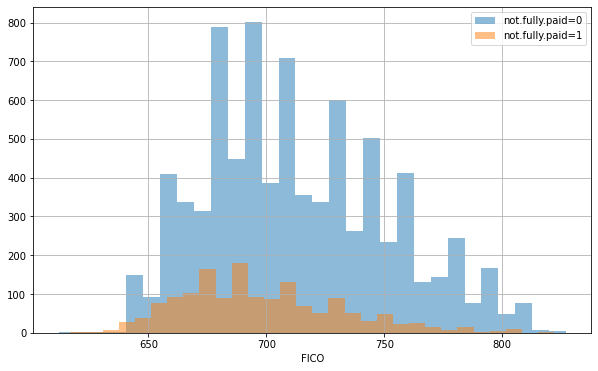

In [19]:
plt.figure(figsize=(10,6))
df[df['not.fully.paid']==0]['fico'].hist(bins=30, label='not.fully.paid=0', alpha=0.5, ls='dashed', lw=3)
df[df['not.fully.paid']==1]['fico'].hist(bins=30, label='not.fully.paid=1', alpha=0.5, ls='dotted', lw=3)
plt.legend()
plt.xlabel('FICO')

** Create a countplot using seaborn showing the counts of loans by purpose, with the color hue defined by not.fully.paid. **

<AxesSubplot:xlabel='purpose', ylabel='count'>

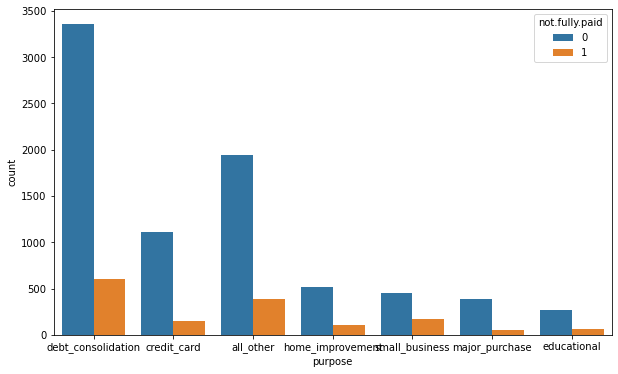

In [21]:
plt.figure(figsize=(10,6))
sns.countplot(x='purpose', hue='not.fully.paid', data=df)

** Let's see the trend between FICO score and interest rate. Recreate the following jointplot.**

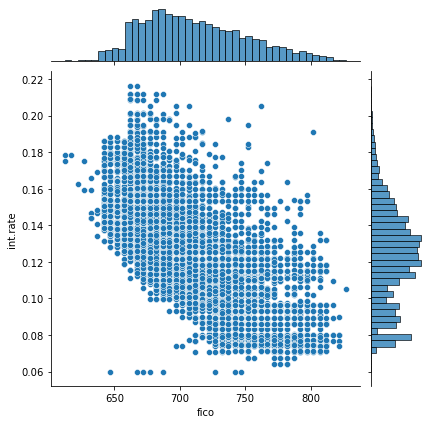

In [22]:
sns.jointplot(x='fico', y='int.rate', data=df)

** Create the following lmplots to see if the trend differed between not.fully.paid and credit.policy. Check the documentation for lmplot() if you can't figure out how to separate it into columns.**

<Figure size 720x432 with 0 Axes>

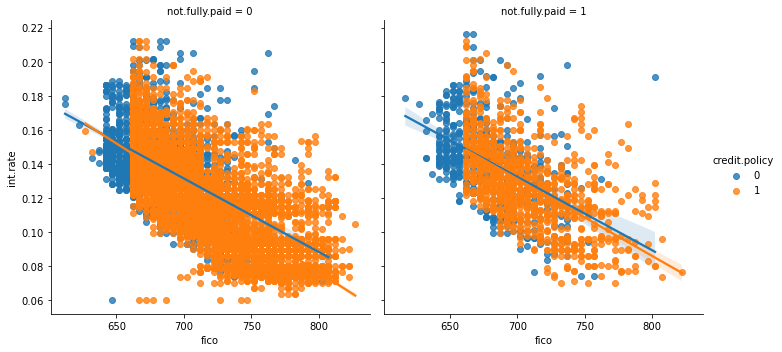

In [24]:
plt.figure(figsize=(10,6))
sns.lmplot(x='fico', y='int.rate', data=df, hue='credit.policy', col='not.fully.paid')

# Setting up the Data

Let's get ready to set up our data for our Random Forest Classification Model!

**Check loans.info() again.**

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


## Categorical Features

Notice that the **purpose** column as categorical

That means we need to transform them using dummy variables so sklearn will be able to understand them. Let's do this in one clean step using pd.get_dummies.

Let's show you a way of dealing with these columns that can be expanded to multiple categorical features if necessary.

**Create a list of 1 element containing the string 'purpose'. Call this list cat_feats.**

In [26]:
cat_feats = ['purpose']

**Now use pd.get_dummies(loans,columns=cat_feats,drop_first=True) to create a fixed larger dataframe that has new feature columns with dummy variables. Set this dataframe as final_data.**

In [27]:
final_data = pd.get_dummies(df,columns=cat_feats,drop_first=True)

In [28]:
final_data

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2,0,0,1,0,0,0,0,0,0
9574,0,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5,0,0,1,0,0,0,0,0,0
9575,0,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8,0,0,1,0,1,0,0,0,0
9576,0,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5,0,0,1,0,0,0,1,0,0


## Train Test Split

Now its time to split our data into a training set and a testing set!

** Use sklearn to split your data into a training set and a testing set as we've done in the past.**

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X = final_data.drop('not.fully.paid', axis=1)
y = final_data['not.fully.paid']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## Training a Decision Tree Model

Let's start by training a single decision tree first!

** Import DecisionTreeClassifier**

In [31]:
from sklearn.tree import DecisionTreeClassifier

**Create an instance of DecisionTreeClassifier() called dtree and fit it to the training data.**

In [32]:
dtree = DecisionTreeClassifier()

In [33]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

## Predictions and Evaluation of Decision Tree
**Create predictions from the test set and create a classification report and a confusion matrix.**

In [34]:
predictions = dtree.predict(X_test)

In [35]:
from sklearn.metrics import classification_report, confusion_matrix

In [36]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      2431
           1       0.20      0.24      0.22       443

    accuracy                           0.73      2874
   macro avg       0.53      0.53      0.53      2874
weighted avg       0.75      0.73      0.74      2874



In [37]:
print(confusion_matrix(y_test,predictions))

[[1998  433]
 [ 336  107]]


## Training the Random Forest model

Now its time to train our model!

**Create an instance of the RandomForestClassifier class and fit it to our training data from the previous step.**

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
rfc = RandomForestClassifier(n_estimators=500)

In [40]:
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

## Predictions and Evaluation

Let's predict off the y_test values and evaluate our model.

** Predict the class of not.fully.paid for the X_test data.**

In [41]:
pred = rfc.predict(X_test)

**Now create a classification report from the results. Do you get anything strange or some sort of warning?**

In [42]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2431
           1       0.59      0.02      0.04       443

    accuracy                           0.85      2874
   macro avg       0.72      0.51      0.48      2874
weighted avg       0.81      0.85      0.78      2874



**Show the Confusion Matrix for the predictions.**

In [43]:
print(confusion_matrix(y_test, pred))

[[2424    7]
 [ 433   10]]


# Great Job!